<a href="https://colab.research.google.com/github/alexandrufalk/tensorflow/blob/Master/Image_high_resolution_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import keras
from keras import layers
from keras import ops
from keras.utils import load_img
from keras.utils import array_to_img
from keras.utils import img_to_array
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf  #  only for data preprocessing

import os
import math
import numpy as np

from IPython.display import display

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
root_dir = "/content/drive/MyDrive/Datasets/BSDS500/images/"



#Create training and validation datasets via image_dataset_from_directory.

In [8]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    f"{root_dir}/training",
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,  # No labels expected
)

valid_ds = image_dataset_from_directory(
    f"{root_dir}/validation",
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,  # No labels expected
)

Found 200 files.
Using 160 files for training.
Found 100 files.
Using 20 files for validation.


In [9]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

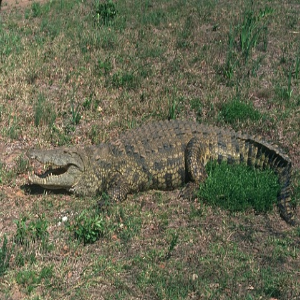

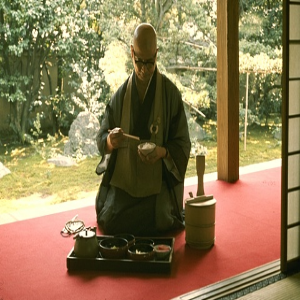

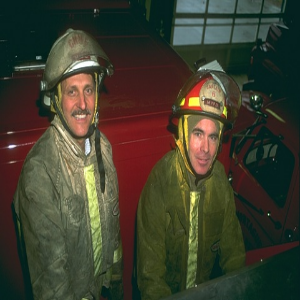

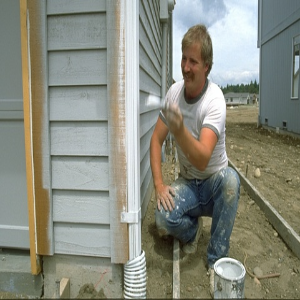

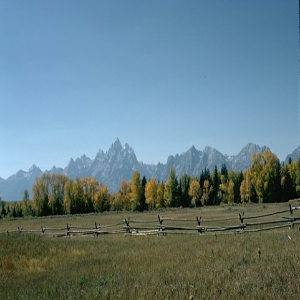

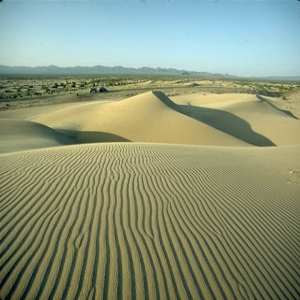

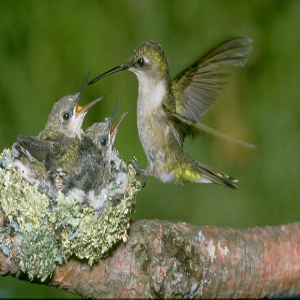

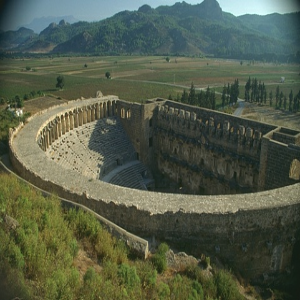

In [10]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

# Prepare a dataset of test image paths that we will use for visual evaluation at the end of this example.

In [11]:
test_path= os.path.join(root_dir, "test")


test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

#Crop and resize images

In [12]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

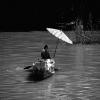

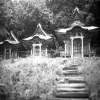

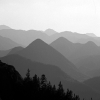

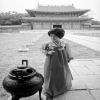

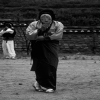

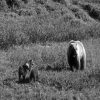

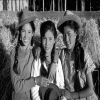

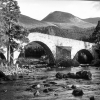

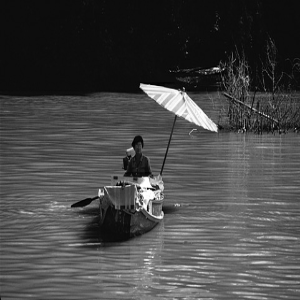

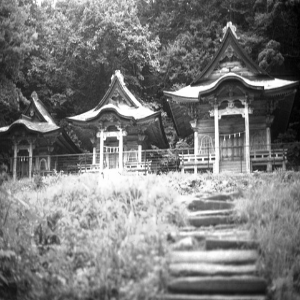

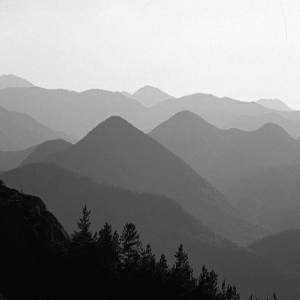

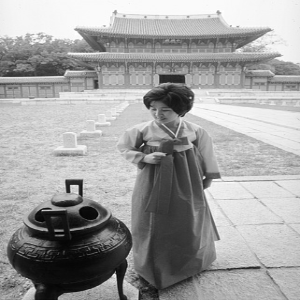

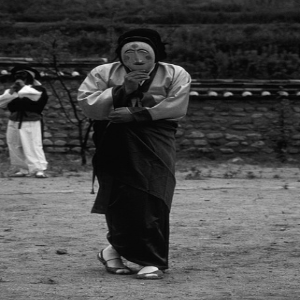

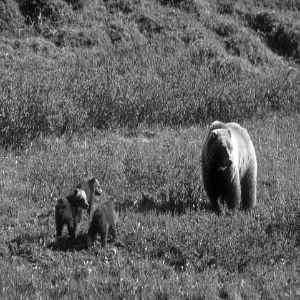

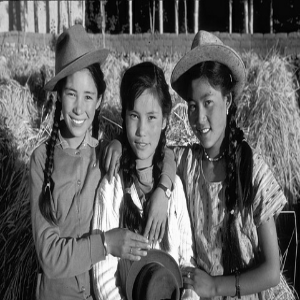

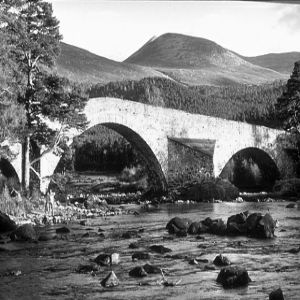

In [13]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

#Build the model

In [14]:
class DepthToSpace(layers.Layer):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size

    def call(self, input):
        batch, height, width, depth = ops.shape(input)
        depth = depth // (self.block_size**2)

        x = ops.reshape(
            input, [batch, height, width, self.block_size, self.block_size, depth]
        )
        x = ops.transpose(x, [0, 1, 3, 2, 4, 5])
        x = ops.reshape(
            x, [batch, height * self.block_size, width * self.block_size, depth]
        )
        return x


def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor**2), 3, **conv_args)(x)
    outputs = DepthToSpace(upscale_factor)(x)

    return keras.Model(inputs, outputs)


#Build a model

In [15]:
class DepthToSpace(layers.Layer):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size

    def call(self, input):
        batch, height, width, depth = ops.shape(input)
        depth = depth // (self.block_size**2)

        x = ops.reshape(
            input, [batch, height, width, self.block_size, self.block_size, depth]
        )
        x = ops.transpose(x, [0, 1, 3, 2, 4, 5])
        x = ops.reshape(
            x, [batch, height * self.block_size, width * self.block_size, depth]
        )
        return x


def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor**2), 3, **conv_args)(x)
    outputs = DepthToSpace(upscale_factor)(x)

    return keras.Model(inputs, outputs)

#Define utility functions

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

#Define callbacks to monitor training

In [17]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [18]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint.keras"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, None, None, 64)      │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, None, None, 32)      │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, None, None, 9)       │           2,601 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depth_to_space (DepthToSpace)        │ (None, None, None, 1)       │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,657 (233.04 KB)

 Trainable params: 59,657 (233.04 KB)

 Non-trainable params: 0 (0.00 B)

#Train the model

Epoch 1/100
Mean PSNR for epoch: 12.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


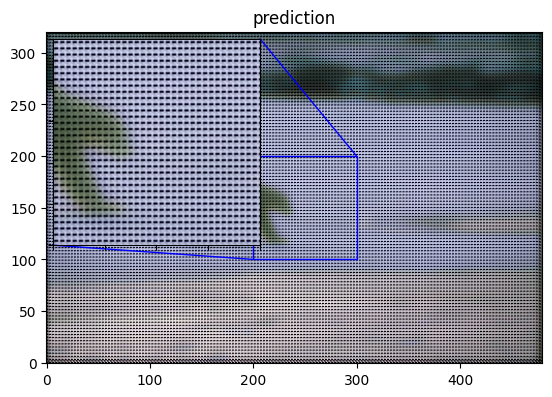

20/20 - 13s - 664ms/step - loss: 0.0812 - val_loss: 0.0583
Epoch 2/100
Mean PSNR for epoch: 15.06
20/20 - 9s - 463ms/step - loss: 0.0450 - val_loss: 0.0328
Epoch 3/100
Mean PSNR for epoch: 20.68
20/20 - 1s - 51ms/step - loss: 0.0304 - val_loss: 0.0083
Epoch 4/100
Mean PSNR for epoch: 22.70
20/20 - 1s - 63ms/step - loss: 0.0073 - val_loss: 0.0050
Epoch 5/100
Mean PSNR for epoch: 24.74
20/20 - 1s - 62ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 6/100
Mean PSNR for epoch: 24.48
20/20 - 1s - 51ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 7/100
Mean PSNR for epoch: 24.73
20/20 - 1s - 51ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 8/100
Mean PSNR for epoch: 25.79
20/20 - 1s - 61ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 9/100
Mean PSNR for epoch: 26.17
20/20 - 1s - 67ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 10/100
Mean PSNR for epoch: 26.22
20/20 - 3s - 135ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 11/100
Mean PSNR for epoch: 26.35
20/20 - 1s - 50ms/step - loss: 0.0

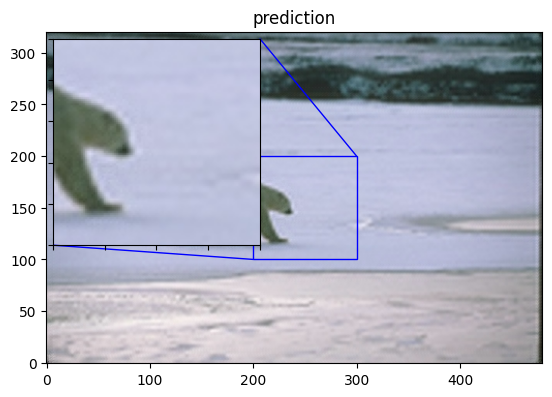

20/20 - 3s - 139ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 22/100
Mean PSNR for epoch: 26.25
20/20 - 2s - 97ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 23/100
Mean PSNR for epoch: 26.35
20/20 - 1s - 53ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 24/100
Mean PSNR for epoch: 26.58
20/20 - 1s - 51ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 25/100
Mean PSNR for epoch: 26.45
20/20 - 1s - 51ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 26/100
Mean PSNR for epoch: 26.15
20/20 - 1s - 47ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 27/100
Mean PSNR for epoch: 26.92
20/20 - 1s - 55ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 28/100
Mean PSNR for epoch: 26.15
20/20 - 2s - 87ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 29/100
Mean PSNR for epoch: 26.41
20/20 - 2s - 91ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 30/100
Mean PSNR for epoch: 25.80
20/20 - 1s - 51ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 31/100
Mean PSNR for epoch: 26.20
20/20 - 1s - 48ms/step - loss

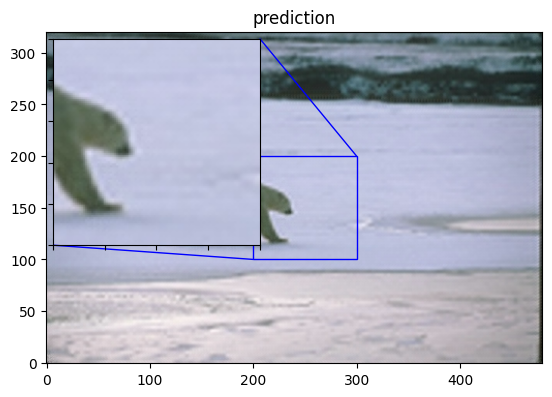

20/20 - 2s - 82ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 42/100
Mean PSNR for epoch: 26.41
20/20 - 2s - 97ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 43/100
Mean PSNR for epoch: 26.54
20/20 - 1s - 59ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 44/100
Mean PSNR for epoch: 26.36
20/20 - 1s - 49ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 45/100
Mean PSNR for epoch: 26.91
20/20 - 2s - 81ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 46/100
Mean PSNR for epoch: 26.64
20/20 - 3s - 130ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 47/100
Mean PSNR for epoch: 27.25
20/20 - 1s - 49ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 48/100
Mean PSNR for epoch: 26.92
20/20 - 1s - 47ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 49/100
Mean PSNR for epoch: 26.51
20/20 - 1s - 50ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 50/100
Mean PSNR for epoch: 26.47
20/20 - 1s - 50ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 51/100
Mean PSNR for epoch: 26.84
20/20 - 1s - 63ms/step - loss

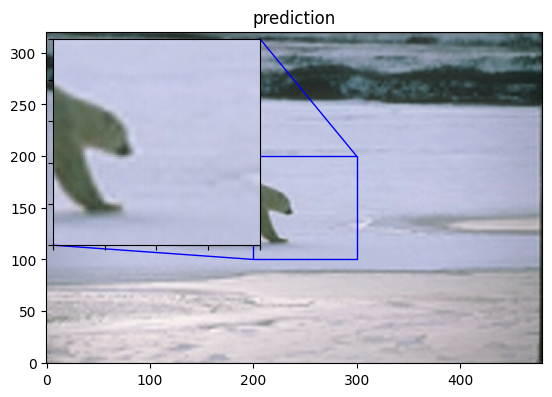

20/20 - 2s - 94ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 62/100
Mean PSNR for epoch: 26.25
20/20 - 2s - 98ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 63/100
Mean PSNR for epoch: 26.40
20/20 - 1s - 69ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 64/100
Mean PSNR for epoch: 26.50
20/20 - 2s - 87ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 65/100
Mean PSNR for epoch: 27.13
20/20 - 2s - 94ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 66/100
Mean PSNR for epoch: 27.35
20/20 - 1s - 50ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 67/100
Mean PSNR for epoch: 26.59
20/20 - 1s - 62ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 68/100
Mean PSNR for epoch: 26.36
20/20 - 1s - 64ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 69/100
Mean PSNR for epoch: 26.91
20/20 - 1s - 61ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 70/100
Mean PSNR for epoch: 26.85
20/20 - 1s - 64ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 71/100
Mean PSNR for epoch: 26.64
20/20 - 1s - 61ms/step - loss:

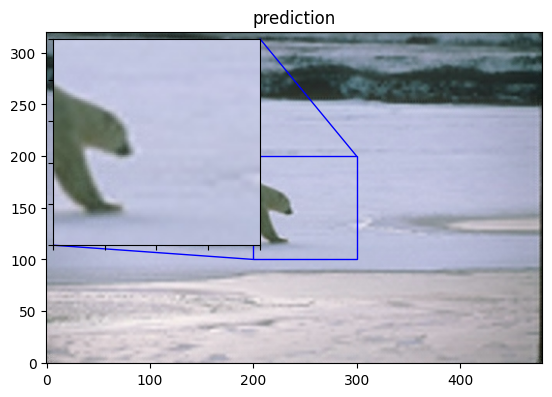

20/20 - 2s - 82ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 82/100
Mean PSNR for epoch: 26.90
20/20 - 3s - 126ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 83/100
Mean PSNR for epoch: 27.00
20/20 - 2s - 98ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 84/100
Mean PSNR for epoch: 26.46
20/20 - 1s - 51ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 85/100
Mean PSNR for epoch: 26.65
20/20 - 1s - 49ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 86/100
Mean PSNR for epoch: 26.77
20/20 - 1s - 63ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 87/100
Mean PSNR for epoch: 26.55
20/20 - 1s - 62ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 88/100
Mean PSNR for epoch: 26.96
20/20 - 1s - 47ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 89/100
Mean PSNR for epoch: 26.55
20/20 - 1s - 64ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 90/100
Mean PSNR for epoch: 27.22
20/20 - 1s - 48ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 91/100
Mean PSNR for epoch: 26.97
20/20 - 1s - 45ms/step - loss

In [19]:
epochs = 100

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)